# PCAWG-QC Star Rating
Imports the QC measures in the form of a tsv (Supplementary Table 1 in the PCAWG-QC paper), calculates which pass for each QC measure and gives a star rating. Various graphs to show various quality measures are also plotted.
		
INPUT: TSV files saved from google sheets containing the data, metadata file linking the projects to tissue types. Numerical calculations are done using the numpy and scipy.stats packages. Graphs are plotted using matplotlib.pyplot package. Also, collections.Counter is needed for manipulation of the data.
		
OUTPUT: A TSV file with the star rating and a series of graphs used to illustrate the different QC measures and the star rating.

In [10]:
%matplotlib inline

### Imports the packages needed for this code

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.stats import gaussian_kde

### First, caculate the thresholds for the Mean/Median Coverage ratio, which are the whiskers from the boxplots of the normal and tumour samples.

In [12]:
f = open('Supplementary_Table_1.tsv', 'r')
line = f.next()

medmean_norm = []
medmean_tumo = []
norm_ids = []


for line in f:
    temp = line.split('\t')
    if (temp[9] != 'NA') and (temp[2] not in norm_ids):
        norm_ids.append(temp[2])
        medmean_norm.append(float(temp[9]))
    if temp[11] != 'NA':
        medmean_tumo.append(float(temp[11]))

f.close()

# Plot it
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot([medmean_norm, medmean_tumo])
ax.set_xticklabels(['Normal', 'Tumour'])
ax.axhline(1, color='k', linestyle='dashed', linewidth=2)

fig_name = 'MeanMed_boxplot.pdf'
fig.savefig(fig_name, bbox_inches='tight')

whiskers = [item.get_ydata() for item in bp['whiskers']]
fig.clf()
print "The Mean/Median Coverage ratio thresholds in use for the normal and tumour samples"
for item in whiskers:
    print item[1]

The Mean/Median Coverage ratio thresholds in use for the normal and tumour samples
0.9879579222
1.056874433
0.9189571386
1.093026567


### Second, collect all the QC data and calculate the star rating for each normal-tumour sample pair.

In [13]:
## Grab the data
f = open('Supplementary_Table_1.tsv', 'r')
line = f.next()

# This lists are for the comparison of the evenness of coverage methods
Med_Mean_size_norm = []
Med_Mean_size_tumo = []
fwhm_norm = []
fwhm_tumo = []

# Empty lists to record the individual qc measures for each list
FWHM_size_normal = []
FWHM_size_tumour = []
MedMean_size_normal = []
MedMean_size_tumour = []
CallPow_size_normal = []
CallPow_size_tumour = []
DiffChrom_size_normal = []
DiffChrom_size_tumour = []
BaseBias_size_normal = []
BaseBias_size_tumour = []
Mean_size_normal = []
Mean_size_tumour = []

FWHM_norm = {}
FWHM_tumo = {}
CallPow = {}
DiffChrom_norm = {}
DiffChrom_tumo = {}
BaseBias_norm ={}
BaseBias_tumo = {}
Mean_norm = {}
Mean_tumo = {}

# Dictionary to store the star ratings 
starred = {}
all_dam = []

# Lists to store the samples which we already have the norm qc measure - so we don't count it twice for when we have samples with multiple tumours
norm_ids_mean = []
norm_ids_fwhm = []
norm_ids_diff = []
norm_ids_base = []
norm_ids_all = []

# Also open a tsv to record the results
g = open('PCAWG-QC_Star_Rating.tsv', 'w')
temp = line.split('\t')
g.write(temp[0] + '\t' + temp[1] + '\t' + temp[2] + '\t' + temp[3]  + '\t' + temp[4] + '\t' + temp[5] + '\tStar_rating\n')

for line in f:
    temp = line.split('\t')

    add = True
    stars = 0

    # Mean
    if temp[7] != 'NA' and temp[8] != 'NA':

        if float(temp[7]) > 25:
            stars += 0.5
            if temp[2] not in norm_ids_mean:
                norm_ids_mean.append(temp[2])
                if temp[0] in Mean_norm:
                    passed = Mean_norm[temp[0]]['pass']
                    passed += 1
                    Mean_norm[temp[0]]['pass'] = passed
                else:
                    passed = {'pass':1, 'fail':0}
                    Mean_norm[temp[0]] = passed

        else:

            if temp[2] not in norm_ids_mean:
                norm_ids_mean.append(temp[2])
                if temp[0] in Mean_norm:
                    failed = Mean_norm[temp[0]]['fail']
                    failed += 1
                    Mean_norm[temp[0]]['fail'] = failed
                else:
                    failed = {'pass':0, 'fail':1}
                    Mean_norm[temp[0]] = failed

        if float(temp[8]) > 30:
            if float(temp[7]) > 25:
                stars += 0.5
            if temp[0] in Mean_tumo:
                passed = Mean_tumo[temp[0]]['pass']
                passed += 1
                Mean_tumo[temp[0]]['pass'] = passed
            else:
                passed = {'pass':1, 'fail':0}
                Mean_tumo[temp[0]] = passed
        else:
            if temp[0] in Mean_tumo:
                failed = Mean_tumo[temp[0]]['fail']
                failed += 1
                Mean_tumo[temp[0]]['fail'] = failed
            else:
                failed = {'pass':0, 'fail':1}
                Mean_tumo[temp[0]] = failed

    else:
        add = False

    # FWHM
    if temp[10] != 'NA' and temp[12] != 'NA' and temp[9] != 'NA' and temp[11] != 'NA':

        if (float(temp[10]) < 0.205) and (whiskers[0][1] <= float(temp[9]) <= whiskers[1][1]):
            stars += 0.5
            norm_pass = True
            if temp[2] not in norm_ids_fwhm:
                norm_ids_fwhm.append(temp[2])
                if temp[0] in FWHM_norm:
                    passed = FWHM_norm[temp[0]]['pass']
                    passed += 1
                    FWHM_norm[temp[0]]['pass'] = passed
                else:
                    passed = {'pass':1, 'fail':0}
                    FWHM_norm[temp[0]] = passed

        elif float(temp[10]) >= 0.205:
            norm_pass = False
            if temp[2] not in norm_ids_fwhm:
                norm_ids_fwhm.append(temp[2])
                if temp[0] in FWHM_norm:
                    failed = FWHM_norm[temp[0]]['fail']
                    failed += 1
                    FWHM_norm[temp[0]]['fail'] = failed
                else:
                    failed = {'pass':0, 'fail':1}
                    FWHM_norm[temp[0]] = failed


        else:
            norm_pass = False
            if temp[2] not in norm_ids_fwhm:
                norm_ids_fwhm.append(temp[2])
                if temp[0] in FWHM_norm:
                    failed = FWHM_norm[temp[0]]['fail']
                    failed += 1
                    FWHM_norm[temp[0]]['fail'] = failed
                else:
                    failed = {'pass':0, 'fail':1}
                    FWHM_norm[temp[0]] = failed


        if (float(temp[12]) < 0.34) and (whiskers[2][1] <= float(temp[11]) <= whiskers[3][1]):
            if norm_pass:
                stars += 0.5
            if temp[0] in FWHM_tumo:
                passed = FWHM_tumo[temp[0]]['pass']
                passed += 1
                FWHM_tumo[temp[0]]['pass'] = passed
            else:
                passed = {'pass':1, 'fail':0}
                FWHM_tumo[temp[0]] = passed

        elif float(temp[12]) >= 0.34: # >= 0.54
            if temp[0] in FWHM_tumo:
                failed = FWHM_tumo[temp[0]]['fail']
                failed += 1
                FWHM_tumo[temp[0]]['fail'] = failed
            else:
                failed = {'pass':0, 'fail':1}
                FWHM_tumo[temp[0]] = failed


        else:
            if temp[0] in FWHM_tumo:
                failed = FWHM_tumo[temp[0]]['fail']
                failed += 1
                FWHM_tumo[temp[0]]['fail'] = failed
            else:
                failed = {'pass':0, 'fail':1}
                FWHM_tumo[temp[0]] = failed

    else:
        add = False

    # Call_Pow
    if temp[13] != 'NA':

        if int(temp[13]) >= 2.6*10**9:
            stars += 1.0
            if temp[0] in CallPow:
                passed = CallPow[temp[0]]['pass']
                passed += 1
                CallPow[temp[0]]['pass'] = passed
            else:
                passed = {'pass':1, 'fail':0}
                CallPow[temp[0]] = passed
        else:
            if temp[0] in CallPow:
                failed = CallPow[temp[0]]['fail']
                failed += 1
                CallPow[temp[0]]['fail'] = failed
            else:
                failed = {'pass':0, 'fail':1}
                CallPow[temp[0]] = failed                

    else:
        add = False

    # Diff_Chrom
    if temp[14] != 'NA' and temp[15] != 'NA':

        if float(temp[14]) < 3:
            stars += 0.5
            if temp[2] not in norm_ids_diff:
                norm_ids_diff.append(temp[2])
                if temp[0] in DiffChrom_norm:
                    passed = DiffChrom_norm[temp[0]]['pass']
                    passed += 1
                    DiffChrom_norm[temp[0]]['pass'] = passed
                else:
                    passed = {'pass':1, 'fail':0}
                    DiffChrom_norm[temp[0]] = passed
        else:

            if temp[2] not in norm_ids_diff:
                norm_ids_diff.append(temp[2])
                if temp[0] in DiffChrom_norm:
                    failed = DiffChrom_norm[temp[0]]['fail']
                    failed += 1
                    DiffChrom_norm[temp[0]]['fail'] = failed
                else:
                    failed = {'pass':0, 'fail':1}
                    DiffChrom_norm[temp[0]] = failed


        if float(temp[15]) < 3:
            if float(temp[14]) < 3:
                stars += 0.5
            if temp[0] in DiffChrom_tumo:
                passed = DiffChrom_tumo[temp[0]]['pass']
                passed += 1
                DiffChrom_tumo[temp[0]]['pass'] = passed
            else:
                passed = {'pass':1, 'fail':0}
                DiffChrom_tumo[temp[0]] = passed
        else:
            if temp[0] in DiffChrom_tumo:
                failed = DiffChrom_tumo[temp[0]]['fail']
                failed += 1
                DiffChrom_tumo[temp[0]]['fail'] = failed
            else:
                failed = {'pass':0, 'fail':1}
                DiffChrom_tumo[temp[0]] = failed

    else:
        add = False

    # Base_Bias
    if temp[16] != 'NA' and temp[17].rstrip() != 'NA':

        if float(temp[16]) < 2:
            stars += 0.5
            if temp[2] not in norm_ids_base:
                norm_ids_base.append(temp[2])
                if temp[0] in BaseBias_norm:
                    passed = BaseBias_norm[temp[0]]['pass']
                    passed += 1
                    BaseBias_norm[temp[0]]['pass'] = passed
                else:
                    passed = {'pass':1, 'fail':0}
                    BaseBias_norm[temp[0]] = passed
        else:

            if temp[2] not in norm_ids_base:
                norm_ids_base.append(temp[2])
            if temp[0] in BaseBias_norm:
                failed = BaseBias_norm[temp[0]]['fail']
                failed += 1
                BaseBias_norm[temp[0]]['fail'] = failed
            else:
                failed = {'pass':0, 'fail':1}
                BaseBias_norm[temp[0]] = failed

        if float(temp[17].rstrip()) < 2:
            if float(temp[16]) < 2:
                stars += 0.5
            if temp[0] in BaseBias_tumo:
                passed = BaseBias_tumo[temp[0]]['pass']
                passed += 1
                BaseBias_tumo[temp[0]]['pass'] = passed
            else:
                passed = {'pass':1, 'fail':0}
                BaseBias_tumo[temp[0]] = passed
        else:
            if temp[0] in BaseBias_tumo:
                failed = BaseBias_tumo[temp[0]]['fail']
                failed += 1
                BaseBias_tumo[temp[0]]['fail'] = failed
            else:
                failed = {'pass':0, 'fail':1}
                BaseBias_tumo[temp[0]] = failed

    else:
        add = False

    if add:
        if temp[0] in starred:
            star_temp = starred[temp[0]]
            star_temp.append(stars)
            starred[temp[0]] = star_temp
        else:
            starred[temp[0]] = [stars]

        all_dam.append(stars)

        if temp[2] not in norm_ids_all:
            norm_ids_all.append(temp[2])
            Med_Mean_size_norm.append(float(temp[9]))
            fwhm_norm.append(float(temp[10]))
            # if float(temp[14]) < 20:
            Mean_size_normal.append(float(temp[7]))
            MedMean_size_normal.append(abs(1-float(temp[9])))
            FWHM_size_normal.append(float(temp[10]))
            CallPow_size_normal.append(float(temp[13]))
            DiffChrom_size_normal.append(float(temp[14]))
            BaseBias_size_normal.append(float(temp[16]))

        Med_Mean_size_tumo.append(float(temp[11]))
        fwhm_tumo.append(float(temp[12]))
        Mean_size_tumour.append(float(temp[8]))
        MedMean_size_tumour.append(abs(1-float(temp[11])))
        FWHM_size_tumour.append(float(temp[12]))
        CallPow_size_tumour.append(float(temp[13]))
        DiffChrom_size_tumour.append(float(temp[15]))
        BaseBias_size_tumour.append(float(temp[17].rstrip()))

        # Write out the star rating to a tsv file
        g.write(temp[0] + '\t' + temp[1] + '\t' + temp[2] + '\t' + temp[3]  + '\t' + temp[4] + '\t' + temp[5] + '\t' + str(stars) + '\n')


    else:
        print 'We do not have complete QC data for this sample'
        print temp[0] + '\t' + temp[1] + '\t' + temp[2] + '\t' + temp[3]  + '\t' + temp[4] + '\t' + temp[5]

f.close()
g.close()

# Get the tissue type linked to each project
f = open('Supplementary_Table_2.tsv', 'r')
tissues = {}
line = f.next()
for line in f:
    temp = line.split('\t')
    if temp[1].strip() in tissues:
        named = tissues[temp[1].strip()]
        named.append(temp[0])
    else:
        named = [temp[0]]
    tissues[temp[1].strip()] = named
f.close()

tissues_sorted = []
for key in tissues:
    tissues_sorted.append(key)
tissues_sorted.sort()

### Third, denisty scatter plots for the nomral and tumour samples, to compare how the two evenness of coverage measures compare

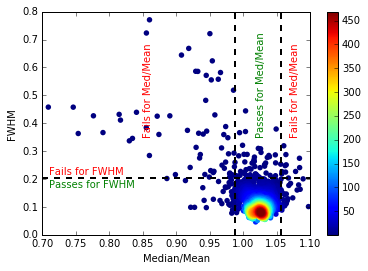

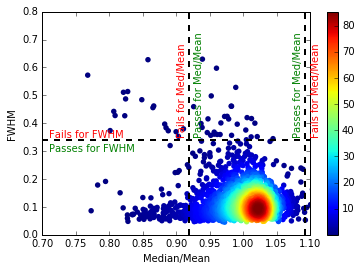

In [14]:
#% Calculate the point density for the normal samples
x = np.array(Med_Mean_size_norm)
y = np.array(fwhm_norm)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Now the actual plot
fig, ax = plt.subplots()

ax.axvline(x=whiskers[0][1], color='k', linestyle='dashed', linewidth=2)
plt.text(.85,0.66, 'Fails for Med/Mean', color='red', rotation=90)

ax.axvline(x=whiskers[1][1], color='k', linestyle='dashed', linewidth=2)
plt.text(1.02,0.7,'Passes for Med/Mean', color='green',rotation=90)
plt.text(1.07,0.66, 'Fails for Med/Mean', color='red', rotation=90)

ax.axhline(y=0.205, color='k', linestyle='dashed', linewidth=2)
plt.text(0.71,0.17,'Passes for FWHM', color='green')
plt.text(0.71,0.215,'Fails for FWHM', color='red')
# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlim(.7,1.1)
ax.set_ylim(0,.8)

cax = ax.scatter(x, y, c=z, s=30, edgecolor='')

fig.colorbar(cax)
ax.set_xlabel('Median/Mean')
ax.set_ylabel('FWHM')

fig_name = 'Evenness_med-mean_fwhm_normal_scattterplot.pdf'
fig.savefig(fig_name)
plt.show()
plt.clf()

#% Calculate the point density for the tumour samples
x = np.array(Med_Mean_size_tumo)
y = np.array(fwhm_tumo)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Now the actual plot
fig, ax = plt.subplots()

ax.axvline(x=whiskers[2][1], color='k', linestyle='dashed', linewidth=2)
plt.text(whiskers[2][1]+.008,0.7,'Passes for Med/Mean', color='green',rotation=90)
plt.text(whiskers[2][1]-.018,0.66, 'Fails for Med/Mean', color='red', rotation=90)

ax.axvline(x=whiskers[3][1], color='k', linestyle='dashed', linewidth=2)
plt.text(whiskers[3][1]-.018,0.7,'Passes for Med/Mean', color='green',rotation=90)
plt.text(whiskers[3][1]+.008,0.66, 'Fails for Med/Mean', color='red', rotation=90)

ax.axhline(y=0.34, color='k', linestyle='dashed', linewidth=2)
plt.text(0.71,0.35,'Fails for FWHM', color='red')
plt.text(0.71,0.3,'Passes for FWHM', color='green')

ax.set_xlim(.7,1.1)
ax.set_ylim(0,.8)

cax = ax.scatter(x, y, c=z, s=30, edgecolor='')

fig.colorbar(cax)
ax.set_xlabel('Median/Mean')
ax.set_ylabel('FWHM')

fig_name = 'Evenness_med-mean_fwhm_tumour_scattterplot.pdf'
fig.savefig(fig_name)
plt.show()
plt.clf()

### Fourth, these are individual plots of the qc data, showing what proportion passed and failed for individual projects. These figures did not make it to the final paper, but are kept here for completeness sake.

For Mean_norm we have 0.353107344633 percent failing (total = 2832)


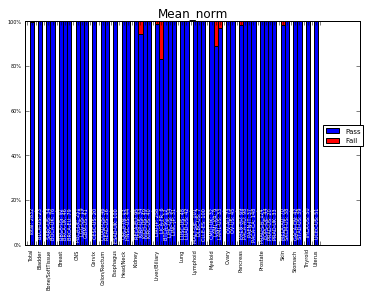

For Mean_tumo we have 2.02771206489 percent failing (total = 2959)


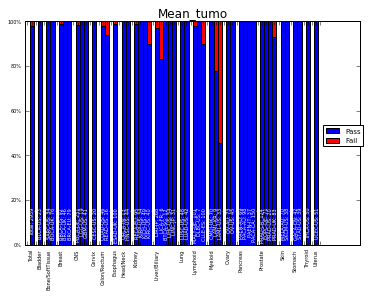

For FWHM_norm we have 6.25 percent failing (total = 2832)


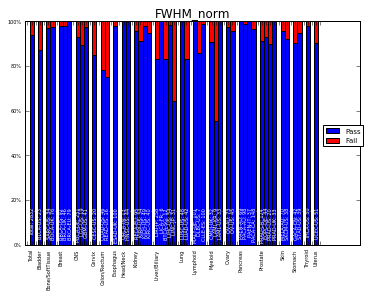

For FWHM_tumo we have 5.81277458601 percent failing (total = 2959)


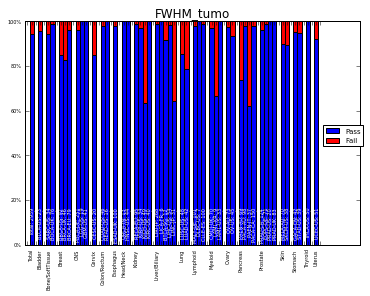

For CallPow we have 4.93409935789 percent failing (total = 2959)


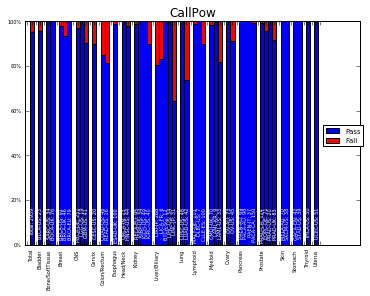

For DiffChrom_norm we have 13.418079096 percent failing (total = 2832)


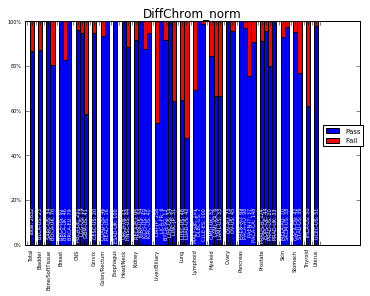

For DiffChrom_tumo we have 12.5718148023 percent failing (total = 2959)


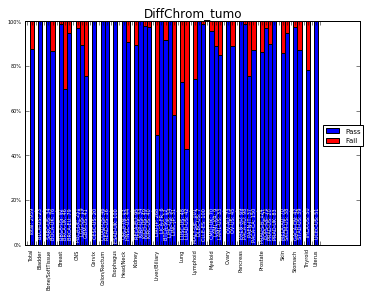

For BaseBias_norm we have 4.87288135593 percent failing (total = 2832)


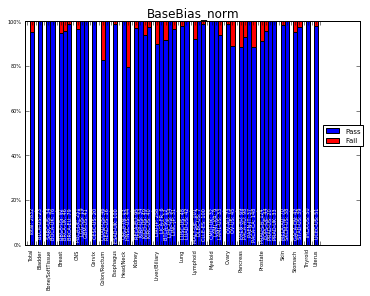

For BaseBias_tumo we have 4.49476174383 percent failing (total = 2959)


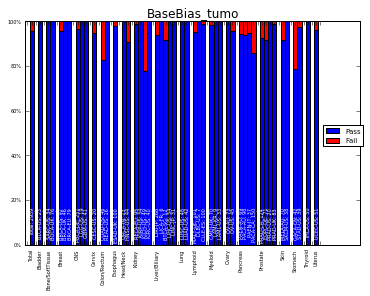

In [15]:
qcs = ['Mean_norm', 'Mean_tumo', 'FWHM_norm', 'FWHM_tumo', 'CallPow', 'DiffChrom_norm', 'DiffChrom_tumo', 'BaseBias_norm', 'BaseBias_tumo']

for k,qc in enumerate([Mean_norm, Mean_tumo, FWHM_norm, FWHM_tumo, CallPow, DiffChrom_norm, DiffChrom_tumo, BaseBias_norm, BaseBias_tumo]):

    faill = 0
    passs = 0

    for key in qc:
        passs += qc[key]['pass']
        faill += qc[key]['fail']

    percent = (faill / float(passs + faill)) * 100

    qc['Total'] = {'fail': faill, 'pass': passs}

    print 'For ' + qcs[k] + ' we have ' + str(percent) + ' percent failing (total = ' + str(passs + faill) + ')'

    labelled = []
    tish = ['', 'Total', '']
    organ = ['', 'Total', '']
    passed = []
    failed = []
    total = []

    for key in qc:
        labelled.append(key)
    labelled.sort()

    for key in tissues_sorted:
        c = True
        for item in tissues[key]:
            if item in labelled:
                tish.append(item)
                if c:
                    organ.append(key)
                    c = False
                else:
                    organ.append(' ')
        tish.append('')
        organ.append('')

    for key in tish:
        if key == '':
            passed.append(0)
            failed.append(0)
            total.append('')
        else:
            pass_temp = qc[key]['pass']
            fail_temp = qc[key]['fail']
            temp = float(pass_temp + fail_temp)
            passed.append(pass_temp/temp * 100)
            failed.append(fail_temp/temp * 100)
            total.append(str(int(temp)))

    N = len(tish)
    ind = np.arange(N)    # the x locations for the groups
    width = 1       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, passed, width, color='blue')
    p2 = plt.bar(ind, failed, width, color='red', bottom=passed)

    plt.title(qcs[k])
    locs, labels = plt.xticks(ind + width/2., (organ))
    plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=5)
    plt.legend((p1[0], p2[0]), ('Pass', 'Fail'), bbox_to_anchor=(1.02, .55), fontsize='x-small')
    plt.ylim(0,100)
    plt.yticks(range(0, 101, 20), [str(x) + "%" for x in range(0, 101, 20)], fontsize=5)

    for j,item in enumerate(ind+0.1):
        plt.text(item,15, tish[j] +': '+ total[j], color='white', size=5, rotation=90, horizontalalignment='left')

    fig_name = '' + qcs[k] + '_project_bias.pdf'
    plt.savefig(fig_name)
    plt.show()
    plt.clf

### Fifth, plots of the star ratings for each project, as well as a bar summarising the star ratings for all the normal-tumour sample pairs in PCAWG.

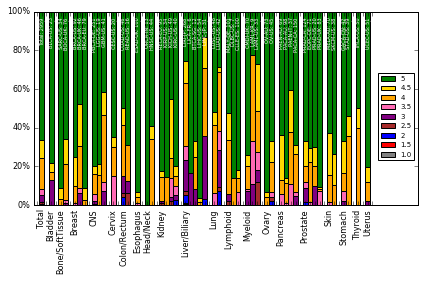

  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  axes: an :class:`~matplotlib.axes.Axes` instance 
  backgroundcolor: any matplotlib color 
  bbox: FancyBboxPatch prop dict 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color: any matplotlib color 
  contains: a callable function 
  family or fontfamily or fontname or name: [FONTNAME | 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace' ] 
  figure: a :class:`matplotlib.figure.Figure` instance 
  fontproperties or font_properties: a :class:`matplotlib.font_manager.FontProperties` instance 
  gid: an id string 
  horizontalalignment or ha: [ 'center' | 'right' | 'left' ] 
  label: string or anything printable with '%s' conversion. 
  linespacing: float (multiple of font size) 
  multialignment: 

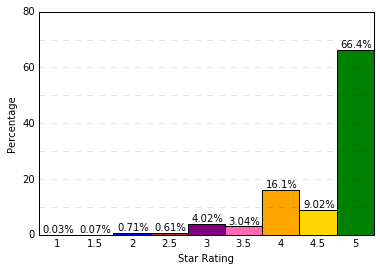

<function matplotlib.pyplot.clf>

In [16]:
# Get the star rating in a usuable form to plot
one = []
onehalf = []
two = []
twohalf = []
three = []
threehalf = []
four = []
fourhalf = []
five = []
total = []

see_all = []
equal_add = True

for key in tish:
    if key != '':
        if key in starred:
            temp = Counter(starred[key])
            if equal_add:
                see_all = temp
                equal_add = False
            else:
                see_all = see_all + temp

            if 1.0 in temp:
                one.append((temp[1.0]/float(len(starred[key])))*100)
            else:
                one.append(0)

            if 1.5 in temp:
                onehalf.append((temp[1.5]/float(len(starred[key])))*100)
            else:
                onehalf.append(0)

            if 2.0 in temp:
                two.append((temp[2.0]/float(len(starred[key])))*100)
            else:
                two.append(0)

            if 2.5 in temp:
                twohalf.append((temp[2.5]/float(len(starred[key])))*100)
            else:
                twohalf.append(0)

            if 3.0 in temp:
                three.append((temp[3.0]/float(len(starred[key])))*100)
            else:
                three.append(0)

            if 3.5 in temp:
                threehalf.append((temp[3.5]/float(len(starred[key])))*100)
            else:
                threehalf.append(0)

            if 4.0 in temp:
                four.append((temp[4.0]/float(len(starred[key])))*100)
            else:
                four.append(0)

            if 4.5 in temp:
                fourhalf.append((temp[4.5]/float(len(starred[key])))*100)
            else:
                fourhalf.append(0)

            if 5.0 in temp:
                five.append((temp[5.0]/float(len(starred[key])))*100)
            else:
                five.append(0)

            total.append(str(len(starred[key])))

        else:
            one.append(0)
            onehalf.append(0)
            two.append(0)
            twohalf.append(0)
            three.append(0)
            threehalf.append(0)
            four.append(0)
            fourhalf.append(0)
            five.append(0)
            total.append('')

    else:
        one.append(0)
        onehalf.append(0)
        two.append(0)
        twohalf.append(0)
        three.append(0)
        threehalf.append(0)
        four.append(0)
        fourhalf.append(0)
        five.append(0)
        total.append('')

vote_all = 0
for item in see_all:
    vote_all += see_all[item]
one[1] = (see_all[1.0]/float(vote_all)) * 100
onehalf[1] = (see_all[1.5]/float(vote_all)) * 100
two[1] = (see_all[2.0]/float(vote_all)) * 100
twohalf[1] = (see_all[2.5]/float(vote_all)) * 100
three[1] = (see_all[3.0]/float(vote_all)) * 100
threehalf[1] = (see_all[3.5]/float(vote_all)) * 100
four[1] = (see_all[4.0]/float(vote_all)) * 100
fourhalf[1] = (see_all[4.5]/float(vote_all)) * 100
five[1] = (see_all[5.0]/float(vote_all)) * 100
total[1] = str(vote_all)

N = len(tish)
ind = np.arange(N)    # the x locations for the groups
width = 1       # the width of the bars: can also be len(x) sequence

pq = plt.bar(ind, one, width, color ='gray')
pp = plt.bar(ind, onehalf, width, color ='red', bottom=one)
p0 = plt.bar(ind, two, width, color= 'blue', bottom =[one[h] + onehalf[h] for h in range(len(threehalf))])
p1 = plt.bar(ind, twohalf, width, color='brown', bottom=[one[h] + onehalf[h] + two[h] for h in range(len(threehalf))])
p2 = plt.bar(ind, three, width, color='purple', bottom=[one[h] + onehalf[h] + two[h] + twohalf[h] for h in range(len(threehalf))])
p3 = plt.bar(ind, threehalf, width, color='hotpink', bottom=[one[h] + onehalf[h] + two[h] + twohalf[h] + three[h] for h in range(len(threehalf))])
p4 = plt.bar(ind, four, width, color='orange', bottom=[one[h] + onehalf[h] + two[h] + twohalf[h] + three[h]+ threehalf[h] for h in range(len(threehalf))])
p5 = plt.bar(ind, fourhalf, width, color='gold', bottom=[one[h] + onehalf[h] + two[h] + twohalf[h] + three[h] + threehalf[h] + four[h] for h in range(len(threehalf))])
p6 = plt.bar(ind, five, width, color='green', bottom=[one[h] + onehalf[h] + two[h] + twohalf[h] + three[h] + threehalf[h] + four[h] + fourhalf[h] for h in range(len(threehalf))])

locs, labels = plt.xticks(ind + width/2., (organ))
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.legend((p6[0], p5[0], p4[0], p3[0], p2[0], p1[0], p0[0], pp[0], pq[0]), ('5', '4.5', '4', '3.5', '3', '2.5', '2', '1.5', '1.0'), bbox_to_anchor=(1, .7), fontsize='x-small')
plt.ylim(0,100)
plt.yticks(range(0, 101, 20), [str(x) + "%" for x in range(0, 101, 20)], fontsize=8)

for j,item in enumerate(ind+0.1):
    plt.text(item,95, tish[j] +': '+ total[j], color='white', size=5, rotation=90, horizontalalignment='left')

plt.tight_layout()    
fig_name = 'starred_project_bias.pdf'
plt.savefig(fig_name)
plt.show()
plt.clf

#% Now lets get a star plot of stars with all bars
one = []
onehalf = []
two = []
twohalf = []
three = []
threehalf = []
four = []
fourhalf = []
five = []
total =[]

temp = Counter(all_dam)
if 1.0 in temp:
    one.append((temp[1.0]/float(len(all_dam)))*100)
else:
    one.append(0)

if 1.5 in temp:
    onehalf.append((temp[1.5]/float(len(all_dam)))*100)
else:
    onehalf.append(0)

if 2.0 in temp:
    two.append((temp[2.0]/float(len(all_dam)))*100)
else:
    two.append(0)

if 2.5 in temp:
    twohalf.append((temp[2.5]/float(len(all_dam)))*100)
else:
    twohalf.append(0)

if 3.0 in temp:
    three.append((temp[3.0]/float(len(all_dam)))*100)
else:
    three.append(0)

if 3.5 in temp:
    threehalf.append((temp[3.5]/float(len(all_dam)))*100)
else:
    threehalf.append(0)

if 4.0 in temp:
    four.append((temp[4.0]/float(len(all_dam)))*100)
else:
    four.append(0)

if 4.5 in temp:
    fourhalf.append((temp[4.5]/float(len(all_dam)))*100)
else:
    fourhalf.append(0)

if 5.0 in temp:
    five.append((temp[5.0]/float(len(all_dam)))*100)
else:
    five.append(0)

total.append(len(all_dam))

N = 9
ind = np.arange(N)    # the x locations for the groups
width = 1       # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
pq = ax.bar(ind[0], one, width, color='gray')
pp = ax.bar(ind[1], onehalf, width, color='red')
p0 = ax.bar(ind[2], two, width, color='blue')
p1 = ax.bar(ind[3], twohalf, width, color='brown')
p2 = ax.bar(ind[4], three, width, color='purple')
p3 = ax.bar(ind[5], threehalf, width, color='hotpink')
p4 = ax.bar(ind[6], four, width, color='orange')
p5 = ax.bar(ind[7], fourhalf, width, color='gold')
p6 = ax.bar(ind[8], five, width, color='green')

ax.set_ylabel('Percentage')
ax.set_xlabel('Star Rating')
locs, labels = plt.xticks(ind + width/2., (['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']))
plt.setp(labels)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.yticks(range(0, 81, 20), [str(x) for x in range(0, 91, 20)], fontsize=10)
plt.ylim(0,80)


for y in range(10, 91, 10):
    plt.plot(range(0, 10), [y] * len(range(0, 10)), "--", lw=0.5, color="black", alpha=0.2)

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.
plt.tick_params(axis="both", which="both", bottom="off", top="off",
                labelbottom="on", left="off", right="off", labelleft="on")

total = [one[0], onehalf[0], two[0], twohalf[0], three[0], threehalf[0], four[0], fourhalf[0], five[0]]
for j,item in enumerate(ind+0.1):
    if total[j] < 1:
        rounded = str(round(total[j],2)) + '%'
    else:
        rounded = str(float('%.3g' % total[j]))  + '%'
    plt.text(item,total[j]+0.8, rounded, color='black', size=10) #absolute[j]

fig_name = 'all_stars.pdf'
plt.savefig(fig_name)
plt.show()
plt.clf

### Finally histograms to show the distributions of each QC measure for normal and tumour samples.

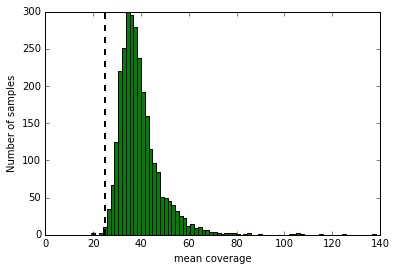

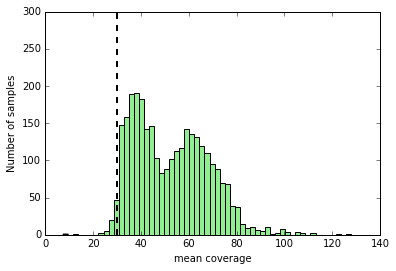

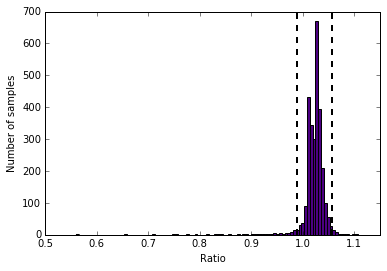

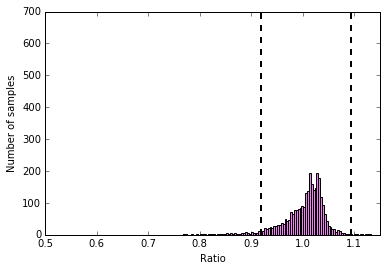

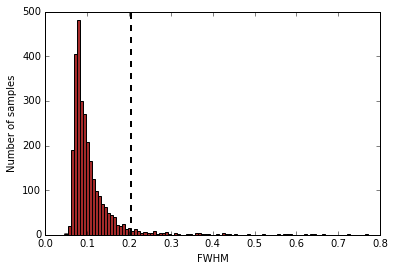

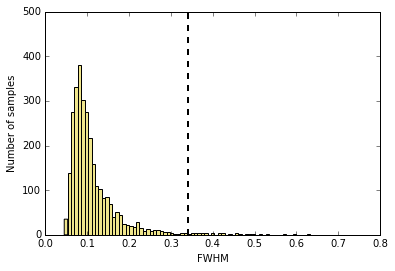

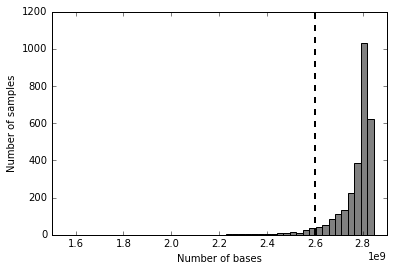

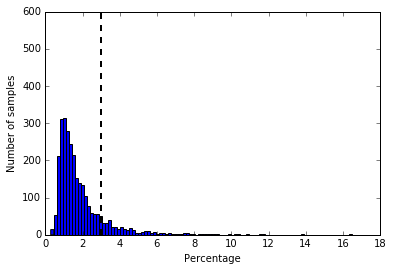

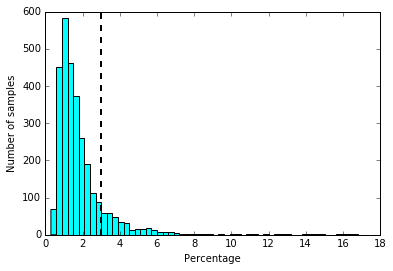

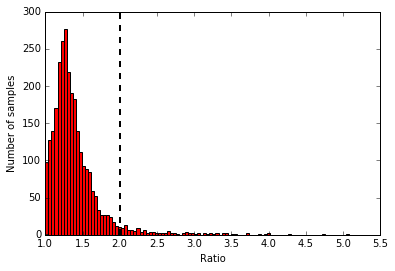

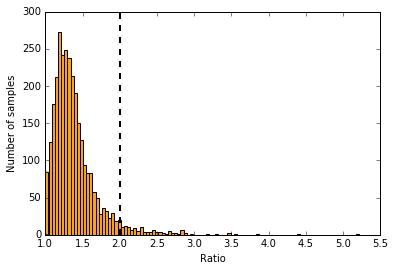

In [17]:
miscellanea = {'Mean_size_normal': [['green', 25], ['Mean coverage for normal', 'mean coverage', 'Number of samples'], [0,140], [0,300]], 
 'Mean_size_tumour': [['lightgreen', 30], ['Mean coverage for tumour', 'mean coverage', 'Number of samples'], [0,140], [0,300]], 
 'Med_Mean_size_norm': [['indigo', whiskers[0][1],whiskers[1][1]], ['Ratio of the median coverage over the mean coverage for normal', 'Ratio', 'Number of samples'], [0.5,1.15], [0,700]], 
 'Med_Mean_size_tumo': [['violet', whiskers[2][1],whiskers[3][1]], ['Ratio of the median coverage over the mean coverage for tumour', 'Ratio', 'Number of samples'], [0.5,1.15], [0,700]], 
 'FWHM_size_normal': [['brown', 0.205], ['FWHM for normal', 'FWHM', 'Number of samples'], [0,0.8], [0,500]], 
 'FWHM_size_tumour': [['khaki', 0.34], ['FWHM for tumour', 'FWHM', 'Number of samples'], [0,0.8], [0,500]], 
 'CallPow_size_normal': [['grey', 2.6*10**9], ['Somatic mutation calling power', 'Number of bases', 'Number of samples'], [1.5*10**9,2.9*10**9], [0,1200]],
 'DiffChrom_size_normal': [['blue', 3], ['Paired reads mapping to different chromosomes for normal', 'Percentage', 'Number of samples'], [0,18], [0,600]], 
 'DiffChrom_size_tumour': [['aqua', 3], ['Paired reads mapping to different chromosomes for tumour', 'Percentage', 'Number of samples'], [0,18], [0,600]], 
 'BaseBias_size_normal': [['red', 2], ['Ratio of difference in edits between paired reads for normal', 'Ratio', 'Number of samples'], [1,5.5], [0,300]], 
 'BaseBias_size_tumour': [['orange', 2], ['Ratio of difference in edits between paired reads for tumour', 'Ratio', 'Number of samples'], [1,5.5], [0,300]]}    

# Histograms
qcs = ['Mean_size_normal', 'Mean_size_tumour', 'Med_Mean_size_norm', 'Med_Mean_size_tumo', 'FWHM_size_normal', 'FWHM_size_tumour', 'CallPow_size_normal', 'DiffChrom_size_normal', 'DiffChrom_size_tumour', 'BaseBias_size_normal', 'BaseBias_size_tumour']

for k,qc in enumerate([Mean_size_normal, Mean_size_tumour, Med_Mean_size_norm, Med_Mean_size_tumo, FWHM_size_normal, FWHM_size_tumour, CallPow_size_normal, DiffChrom_size_normal, DiffChrom_size_tumour, BaseBias_size_normal, BaseBias_size_tumour]):

    to_del = []
    if qcs[k] == 'DiffChrom_size_normal':
        for j,item in enumerate(qc):
            if item > 20:
                to_del.append(j)

        to_del.reverse()
        for index in to_del:
            del qc[index]

    elif qcs[k] == 'FWHM_size_tumour':
        for j,item in enumerate(qc):
            if item > 1:
                to_del.append(j)

        to_del.reverse()
        for index in to_del:
            del qc[index]

    if len(miscellanea[qcs[k]][0]) == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        result = ax.hist(qc, bins=100, color=miscellanea[qcs[k]][0][0])

        ax.axvline(miscellanea[qcs[k]][0][1], color='k', linestyle='dashed', linewidth=2)
        # ax.set_title(miscellanea[qcs[k]][1][0])
        ax.set_xlabel(miscellanea[qcs[k]][1][1])
        ax.set_ylabel(miscellanea[qcs[k]][1][2])
        ax.set_xlim(miscellanea[qcs[k]][2][0] ,miscellanea[qcs[k]][2][1])
        ax.set_ylim(miscellanea[qcs[k]][3][0] ,miscellanea[qcs[k]][3][1])

        fig.savefig(qcs[k] + '_histogram.pdf')

    elif len(miscellanea[qcs[k]][0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        result = ax.hist(qc, bins=100, color=miscellanea[qcs[k]][0][0])

        ax.axvline(miscellanea[qcs[k]][0][1], color='k', linestyle='dashed', linewidth=2)
        ax.axvline(miscellanea[qcs[k]][0][2], color='k', linestyle='dashed', linewidth=2)
        # ax.set_title(miscellanea[qcs[k]][1][0])
        ax.set_xlabel(miscellanea[qcs[k]][1][1])
        ax.set_ylabel(miscellanea[qcs[k]][1][2])
        ax.set_xlim(miscellanea[qcs[k]][2][0] ,miscellanea[qcs[k]][2][1])
        ax.set_ylim(miscellanea[qcs[k]][3][0] ,miscellanea[qcs[k]][3][1])

        fig.savefig(qcs[k] + '_histogram.pdf')